# <center> AAPL - Apple Inc. </center> 
#  <center> Time Series Forecasting with ARIMA and Prophet</center> 
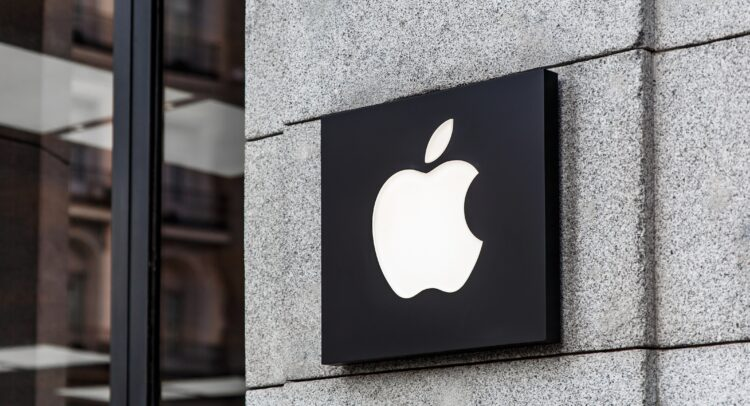

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA models to predict future stock prices.

In [38]:
# !pip install prophet
# !pip install yfinance
# !pip install pmdarima

In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [40]:
df = yf.download("AAPL", start="2020-01-01")
df = df.resample('MS').mean() # Resample the data to get monthly averages
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,77.792738,78.581547,77.207857,77.979048,75.682496,1.397319e+08
2020-02-01,77.578421,78.813158,76.681579,77.817631,75.666462,1.589094e+08
2020-03-01,65.268410,67.423181,63.711591,65.611023,63.829851,2.854578e+08
2020-04-01,67.952857,68.945357,67.021072,68.096547,66.247898,1.554904e+08
2020-05-01,77.221375,78.312875,76.595250,77.496376,75.547774,1.402968e+08


In [41]:
df.shape

(57, 6)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2020-01-01 to 2024-09-01
Freq: MS
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       57 non-null     float64
 1   High       57 non-null     float64
 2   Low        57 non-null     float64
 3   Close      57 non-null     float64
 4   Adj Close  57 non-null     float64
 5   Volume     57 non-null     float64
dtypes: float64(6)
memory usage: 3.1 KB


## Data visualization

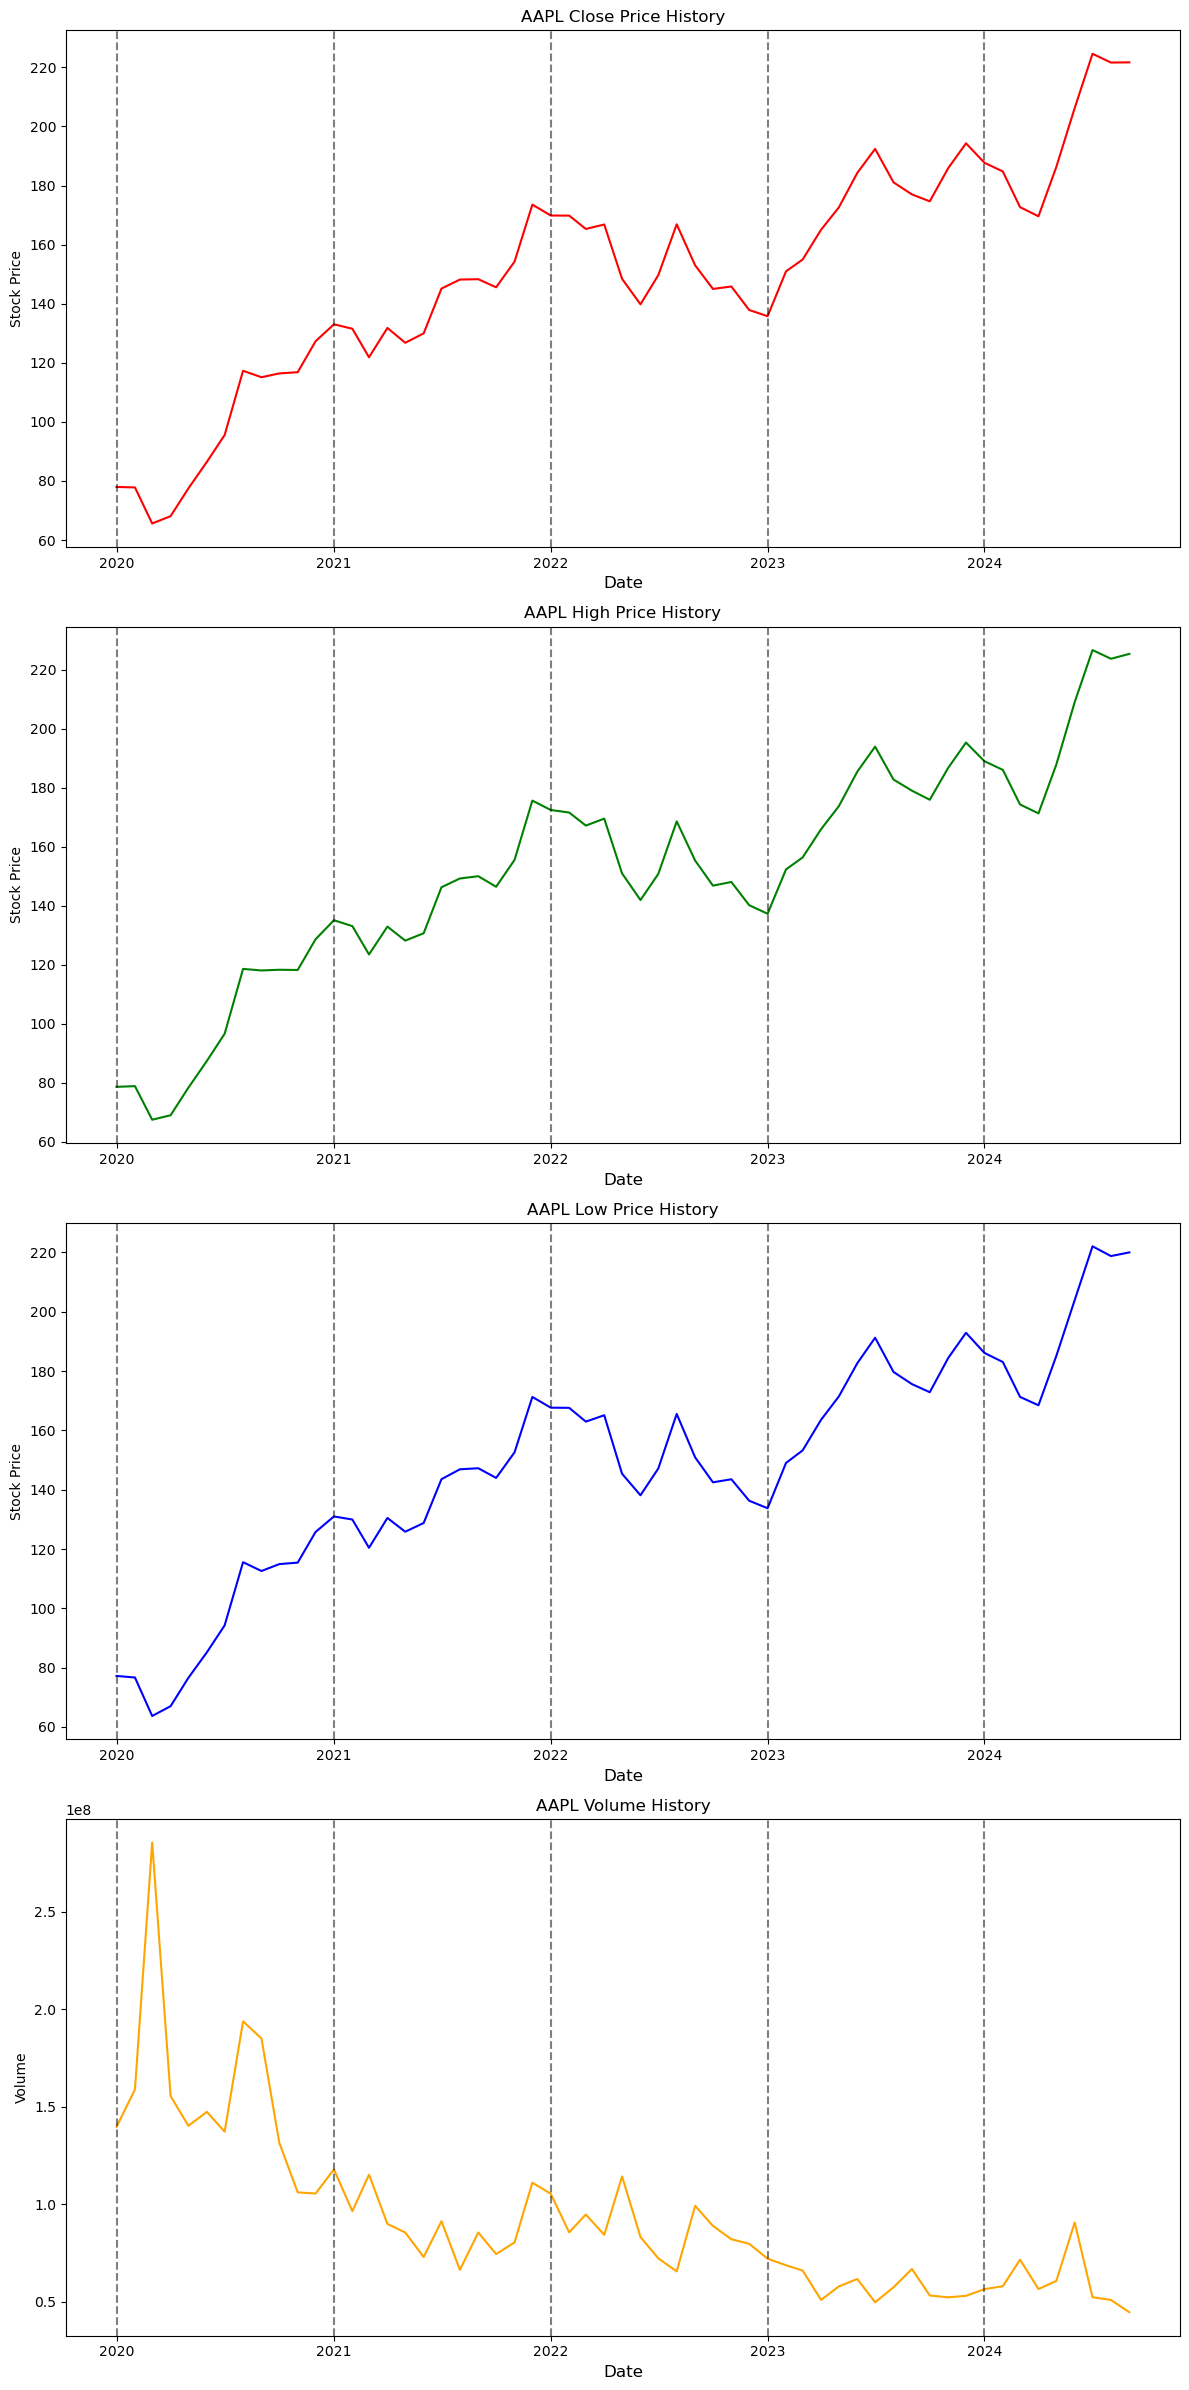

In [43]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AAPL Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("AAPL High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price")
ax3.set_title("AAPL Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("AAPL Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

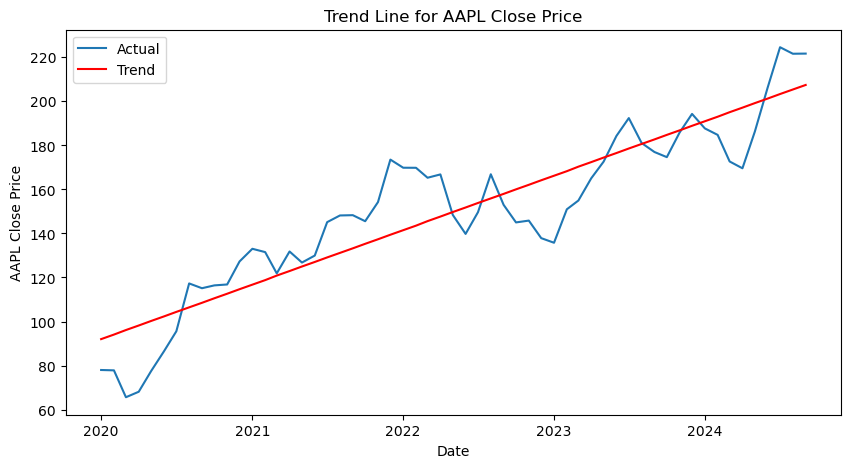

In [44]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

The upward trend in AAPL's stock price reflects Apple's continuous innovation, global expansion, strong brand loyalty, and integration of AI in their products, driving sustained investor confidence and growth.

## Time Series Decomposition

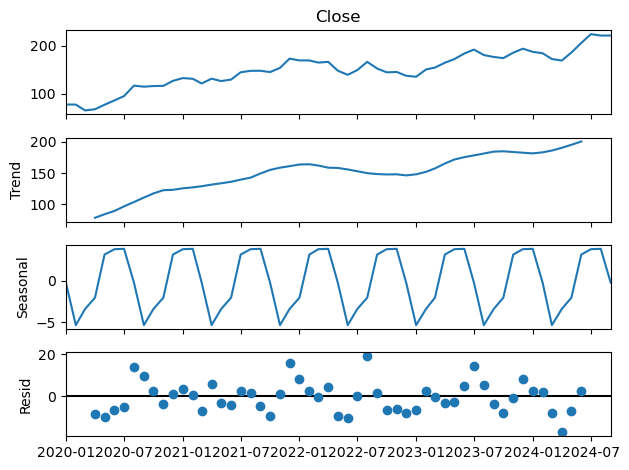

In [45]:
result = seasonal_decompose(df['Close'], model='additive', period=7)
result.plot()
plt.tight_layout()
plt.show()

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [46]:
df = df.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis= 1)
df.head()

,Close
Date,
2020-01-01,77.979048
2020-02-01,77.817631
2020-03-01,65.611023
2020-04-01,68.096547
2020-05-01,77.496376


## Train / Test Split

In [47]:
split_point = int(len(df) * 0.8)  # 80% split index
df_train = df.iloc[:split_point]  # First 80% for training
df_test = df.iloc[split_point:]   # Remaining 20% for testing

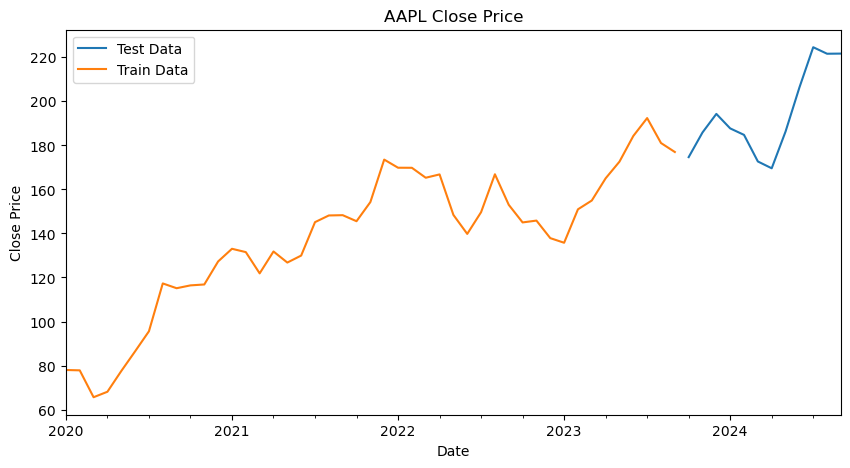

In [48]:
# Plot train and test so we can see where we have split
df_test \
    .rename(columns={'Close': 'Test Data'}) \
    .join(df_train.rename(columns={'Close': 'Train Data'}),
          how='outer') \
    .plot(figsize=(10, 5), title='AAPL Close Price', style='-', ms=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## ARIMA

#### Define orders

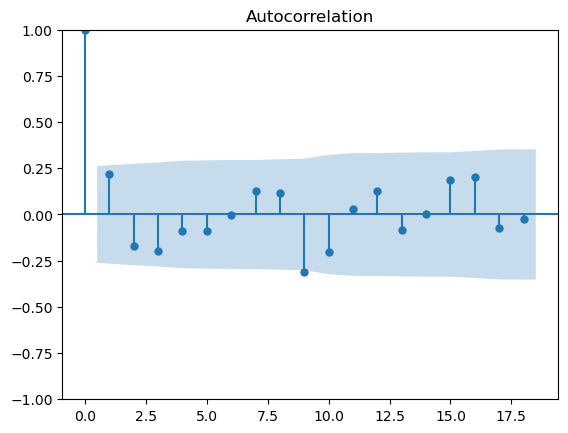

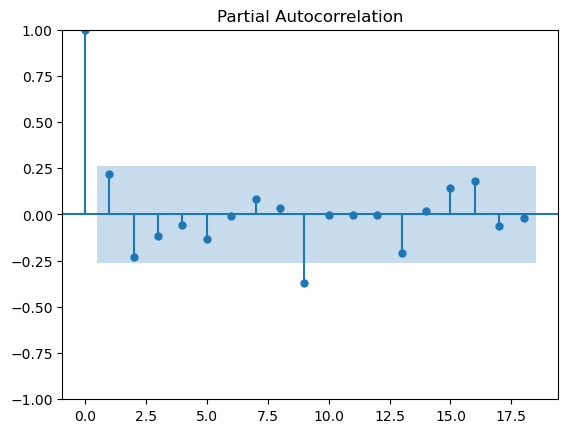

In [49]:
df_diff = df.diff().dropna()
acf_vals = plot_acf(df_diff)
pacf_vals = plot_pacf(df_diff)

##### Initialize and fit an ARIMA model automatically
Automatically selects the best model based on certain criteria (like the ADF test for stationarity and information criteria such as AIC).

In [50]:
model_autoARIMA = auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=337.973, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=334.997, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=330.312, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=328.680, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=330.680, Time=0.06 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.361 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(3, 2, 0)   Log Likelihood                -160.340
Date:                Sat, 07 Sep 2024   AIC                            328.680
Time:                        21:42:27   BIC             

##### Generate predictions

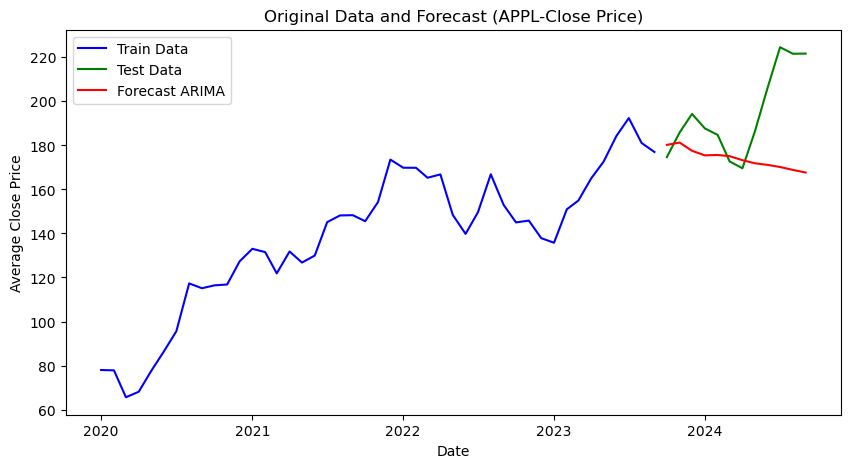

In [51]:
fct_arima = model_autoARIMA.predict(n_periods=len(df_test))

# Create a copy of the original DataFrame to store predictions
df_fct = df.copy()
df_fct['fct_arima'] = None  # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = fct_arima

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')

plt.title('Original Data and Forecast (APPL-Close Price)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

##### Evaluation

In [52]:
mae_arima = mean_absolute_error(df_test, fct_arima)
mape_arima= mean_absolute_percentage_error(df_test, fct_arima) * 100
rmse_arima = np.sqrt(mean_squared_error(df_test, fct_arima))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [mae_arima, f'{mape_arima:.2f}%', rmse_arima],
})

print(performance.set_index('Metrics'))

             ARIMA
Metrics           
MAE      22.090868
MAPE        10.54%
RMSE     29.845319


#### ARIMA Cross-Validation

In [53]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    model = ARIMA(train, order=model_autoARIMA.order)
    model_fit = model.fit()  # Fit ARIMA model on training data
    predictions_cv = model_fit.forecast(steps=len(test))  # Predict on test data

# for fold, (train_index, test_index) in enumerate(tscv.split(df)):
#     print(f"Fold {fold+1}:")
#     print(f"  Train length: {len(train_index)}")
#     print(f"  Test length: {len(test_index)}\n")
    
mae_arima_cv = mean_absolute_error(test, predictions_cv)
mape_arima_cv = mean_absolute_percentage_error(test, predictions_cv) * 100
rmse_arima_cv = np.sqrt(mean_squared_error(test, predictions_cv))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [mae_arima, f'{mape_arima:.2f}%', rmse_arima],
    'ARIMA CV': [mae_arima_cv, f'{mape_arima_cv:.2f}%', rmse_arima_cv],
})

print(performance.set_index('Metrics'))

             ARIMA   ARIMA CV
Metrics                      
MAE      22.090868  19.830758
MAPE        10.54%     10.68%
RMSE     29.845319  23.420314


## Prophet

In [54]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_train_prophet.head()

,ds,y
0,2020-01-01,77.979048
1,2020-02-01,77.817631
2,2020-03-01,65.611023
3,2020-04-01,68.096547
4,2020-05-01,77.496376


##### Fit

In [55]:
%%time
model = Prophet()
model.fit(df_train_prophet)

21:42:27 - cmdstanpy - INFO - Chain [1] start processing
21:42:27 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 15.6 ms
Wall time: 255 ms


##### Generate predictions

In [56]:
df_test.head()

,Close
Date,
2023-10-01,174.668638
2023-11-01,185.879523
2023-12-01,194.308501
2024-01-01,187.724284
2024-02-01,184.775500


In [57]:
fct_prophet = model.predict(df_test_prophet)
fct_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-01,172.498272,160.568906,191.971928,172.468299,172.528522,3.293129,3.293129,3.293129,3.293129,3.293129,3.293129,0.0,0.0,0.0,175.791400
1,2023-11-01,173.881494,176.295374,207.741110,173.786916,173.980893,18.408783,18.408783,18.408783,18.408783,18.408783,18.408783,0.0,0.0,0.0,192.290277
2,2023-12-01,175.220097,170.024763,200.993472,175.040626,175.404229,9.940298,9.940298,9.940298,9.940298,9.940298,9.940298,0.0,0.0,0.0,185.160395
3,2024-01-01,176.603319,156.993877,188.322655,176.326053,176.902965,-4.561121,-4.561121,-4.561121,-4.561121,-4.561121,-4.561121,0.0,0.0,0.0,172.042198
4,2024-02-01,177.986542,159.756181,188.960386,177.578962,178.419880,-4.102622,-4.102622,-4.102622,-4.102622,-4.102622,-4.102622,0.0,0.0,0.0,173.883920


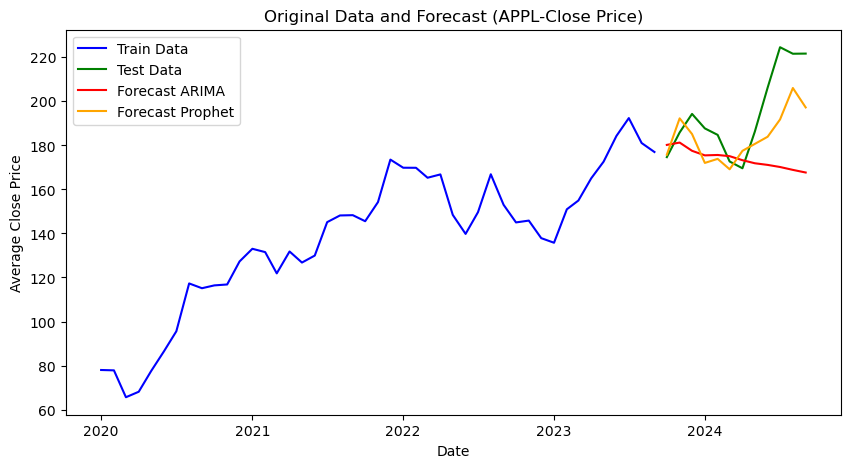

In [58]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Original Data and Forecast (APPL-Close Price)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

##### Prophet Cross validation

In [59]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

,ds,y
0,2020-01-01,77.979048
1,2020-02-01,77.817631
2,2020-03-01,65.611023
3,2020-04-01,68.096547
4,2020-05-01,77.496376


In [60]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

21:42:28 - cmdstanpy - INFO - Chain [1] start processing
21:42:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

21:42:28 - cmdstanpy - INFO - Chain [1] start processing
21:42:28 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing
21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing
21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:30 - cmdstanpy - INFO - Chain [1] start processing
21:42:30 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-04-01,167.489483,163.974708,170.788681,166.820999,2022-03-11
1,2022-05-01,157.151695,153.529915,160.624424,148.430477,2022-03-11
2,2022-06-01,165.097297,162.099598,168.710615,139.798573,2022-03-11
3,2022-07-01,195.183804,191.767497,198.852566,149.670499,2022-03-11
4,2022-08-01,185.824625,182.864454,189.740487,166.885218,2022-03-11


In [61]:
mae_prophet = mean_absolute_error(y_true=df_test,
                   y_pred=fct_prophet['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=fct_prophet['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=fct_prophet['yhat']))

mae_prophet_cv = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet_cv = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet_cv = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
    'Prophet CV': [mae_prophet_cv, f'{mape_prophet_cv:.2f}%', rmse_prophet_cv],
})

print(performance.set_index('Metrics'))

           Prophet Prophet CV
Metrics                      
MAE      12.957527  32.414541
MAPE         6.36%     19.58%
RMSE     15.844758  39.216486


## Comparison of metrics between ARIMA and Prophet models

In [62]:
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [mae_arima, f'{mape_arima:.2f}%', rmse_arima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

             ARIMA    Prophet
Metrics                      
MAE      22.090868  12.957527
MAPE        10.54%      6.36%
RMSE     29.845319  15.844758


#### ✨ The more effective model is the one with the lower MAPE. ✨
Since the dataset is dynamic, please choose the model that shows a lower MAPE for better accuracy.